In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [23]:
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# yf.pdr_override()

In [24]:
# Function to fetch stock data
def fetch_stock_data(tickers, start, end):
    return {ticker: yf.download(ticker, start, end) for ticker in tickers}

In [25]:
# Function to plot stock prices
def plot_stock_prices(company_list, company_name):
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(top=1.25, bottom=1.2)
    
    for i, (company, name) in enumerate(zip(company_list, company_name), 1):
        plt.subplot(2, 2, i)
        company['Adj Close'].plot()
        plt.ylabel('Adj Close')
        plt.xlabel(None)
        plt.title(f"Closing Price of {name}")
        
    plt.tight_layout()
    plt.show()

In [26]:
# Function to plot stock volumes
def plot_stock_volumes(company_list, company_name):
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(top=1.25, bottom=1.2)
    
    for i, (company, name) in enumerate(zip(company_list, company_name), 1):
        plt.subplot(2, 2, i)
        company['Volume'].plot()
        plt.ylabel('Volume')
        plt.xlabel(None)
        plt.title(f"Sales Volume for {name}")
        
    plt.tight_layout()
    plt.show()

In [27]:
# Function to add moving averages
def add_moving_averages(company_list, ma_days):
    for ma in ma_days:
        for company in company_list:
            column_name = f"MA for {ma} days"
            company[column_name] = company['Adj Close'].rolling(ma).mean()

In [28]:
# Function to plot moving averages
def plot_moving_averages(company_list, company_name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    for ax, company, name in zip(axes.flatten(), company_list, company_name):
        company[['Adj Close', f'MA for 10 days', f'MA for 20 days', f'MA for 50 days']].plot(ax=ax)
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

In [29]:
# Function to plot daily returns
def plot_daily_returns(company_list, company_name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    for ax, company, name in zip(axes.flatten(), company_list, company_name):
        company['Daily Return'] = company['Adj Close'].pct_change()
        company['Daily Return'].plot(ax=ax, legend=True, linestyle='--', marker='o')
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

In [30]:
# Function to plot stock correlations
def plot_stock_correlations(tech_rets, closing_df):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
    plt.title('Correlation of stock return')
    
    plt.subplot(2, 2, 2)
    sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
    plt.title('Correlation of stock closing price')
    
    plt.tight_layout()
    plt.show()

In [31]:
# Function to plot risk vs return
def plot_risk_return(rets):
    area = np.pi * 20
    plt.figure(figsize=(10, 8))
    plt.scatter(rets.mean(), rets.std(), s=area)
    plt.xlabel('Expected return')
    plt.ylabel('Risk')
    
    for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
        plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                     arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
    plt.show()

In [32]:
# Function to prepare data for LSTM
def prepare_data_for_lstm(df, feature='Close', train_size=0.95):
    data = df.filter([feature])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * train_size))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len, :]
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train, scaler, training_data_len, data, dataset

In [33]:
# Function to build and train LSTM model
def build_and_train_lstm(x_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    return model, history

In [34]:
def evaluate_lstm(model, scaler, training_data_len, dataset):
    # Create the testing data set
    test_data = scaler.transform(dataset[training_data_len - 60:])
    x_test = [test_data[i-60:i, 0] for i in range(60, len(test_data))]
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # Predict
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    # Calculate RMSE
    y_test = dataset[training_data_len:, :]
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    
    return predictions, rmse

In [35]:
# Function to plot model predictions
def plot_predictions(data, training_data_len, predictions):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()  
    valid['Predictions'] = predictions
    
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price INR (₹)', fontsize=18)
    plt.plot(train['Close'], label='Train')
    plt.plot(valid[['Close', 'Predictions']], label='Valid and Predictions')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the table
    print(valid[['Close', 'Predictions']].head())  
    return valid[['Close', 'Predictions']]


In [36]:
tech_list = ['INFY.NS', 'INOXWIND.NS', 'TATAPOWER.NS', 'HBLPOWER.NS']
company_name = ["Infosys", "Inox-Wind", "TATAPOWER", "HBLPOWER"]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [37]:
stock_data = fetch_stock_data(tech_list, start, end)
company_list = list(stock_data.values())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


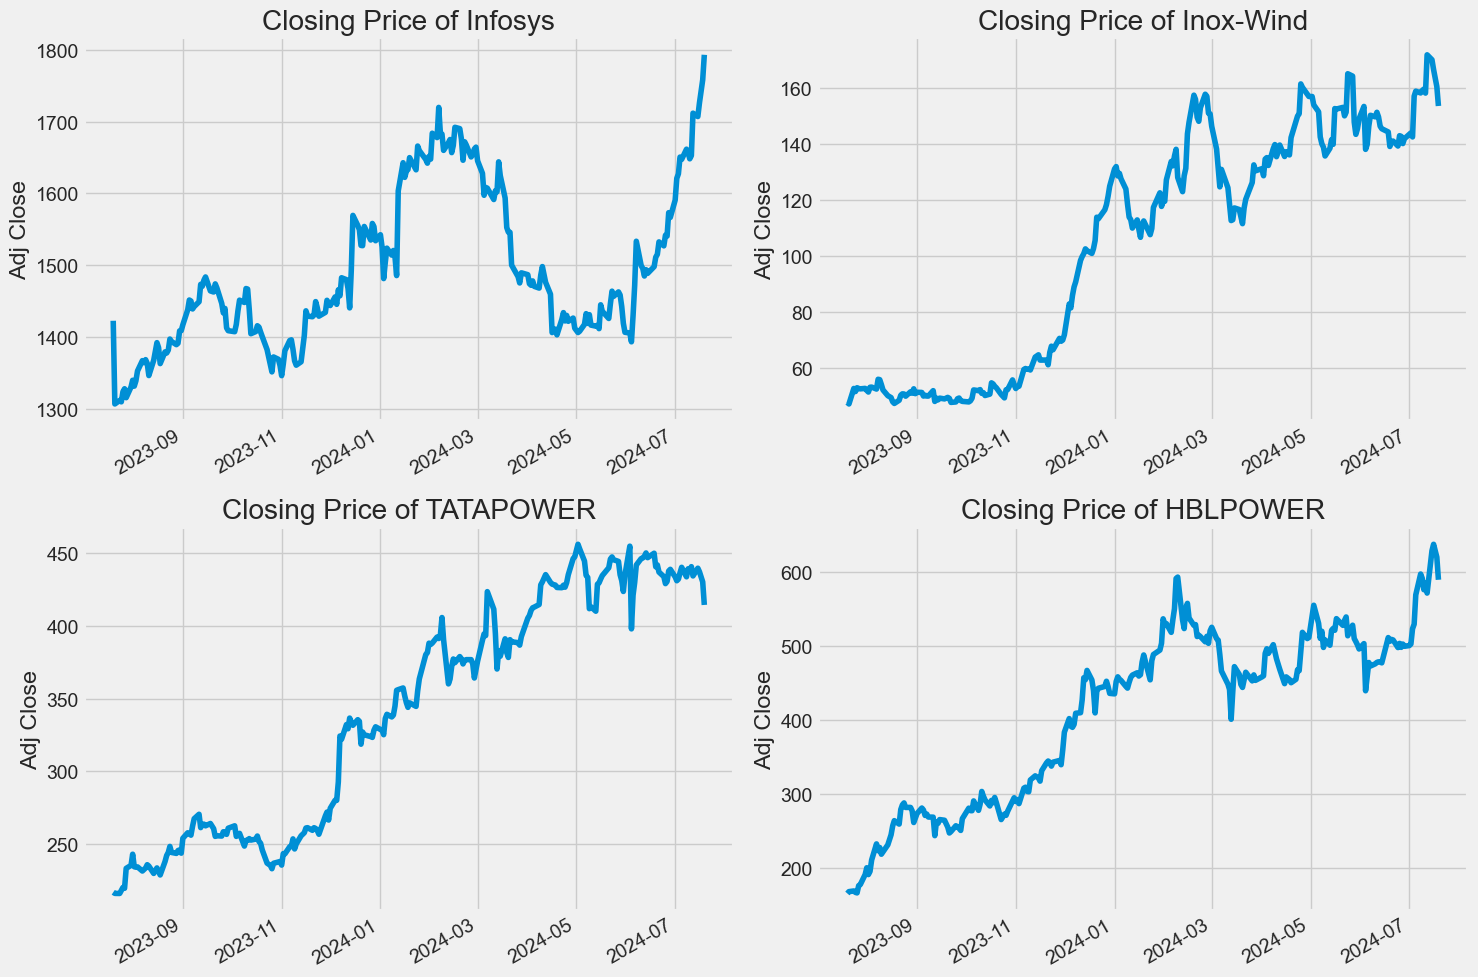

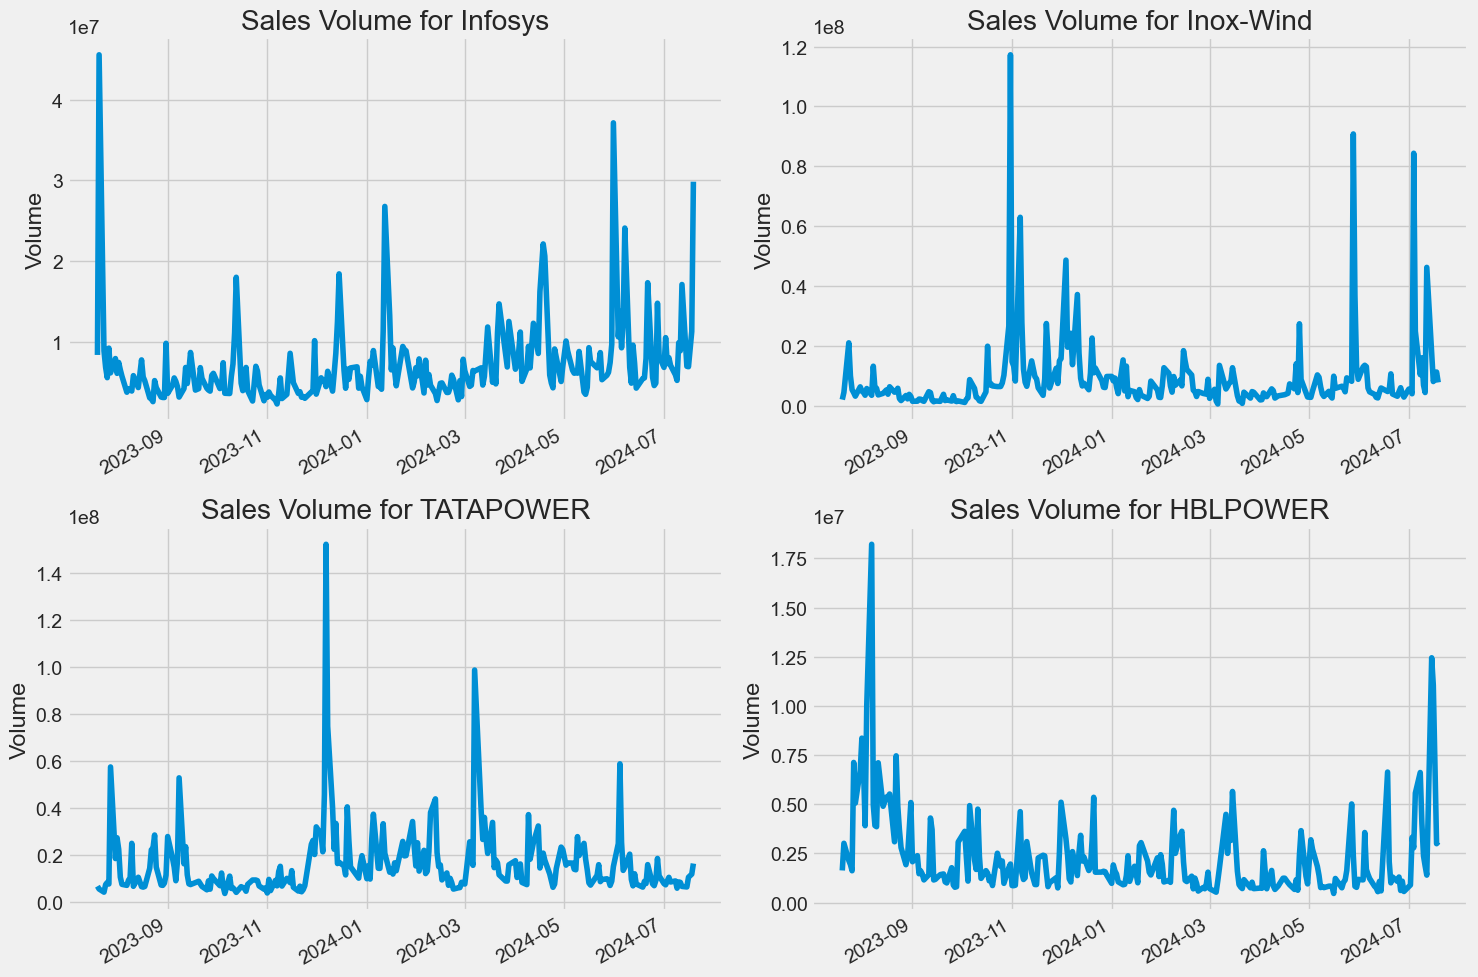

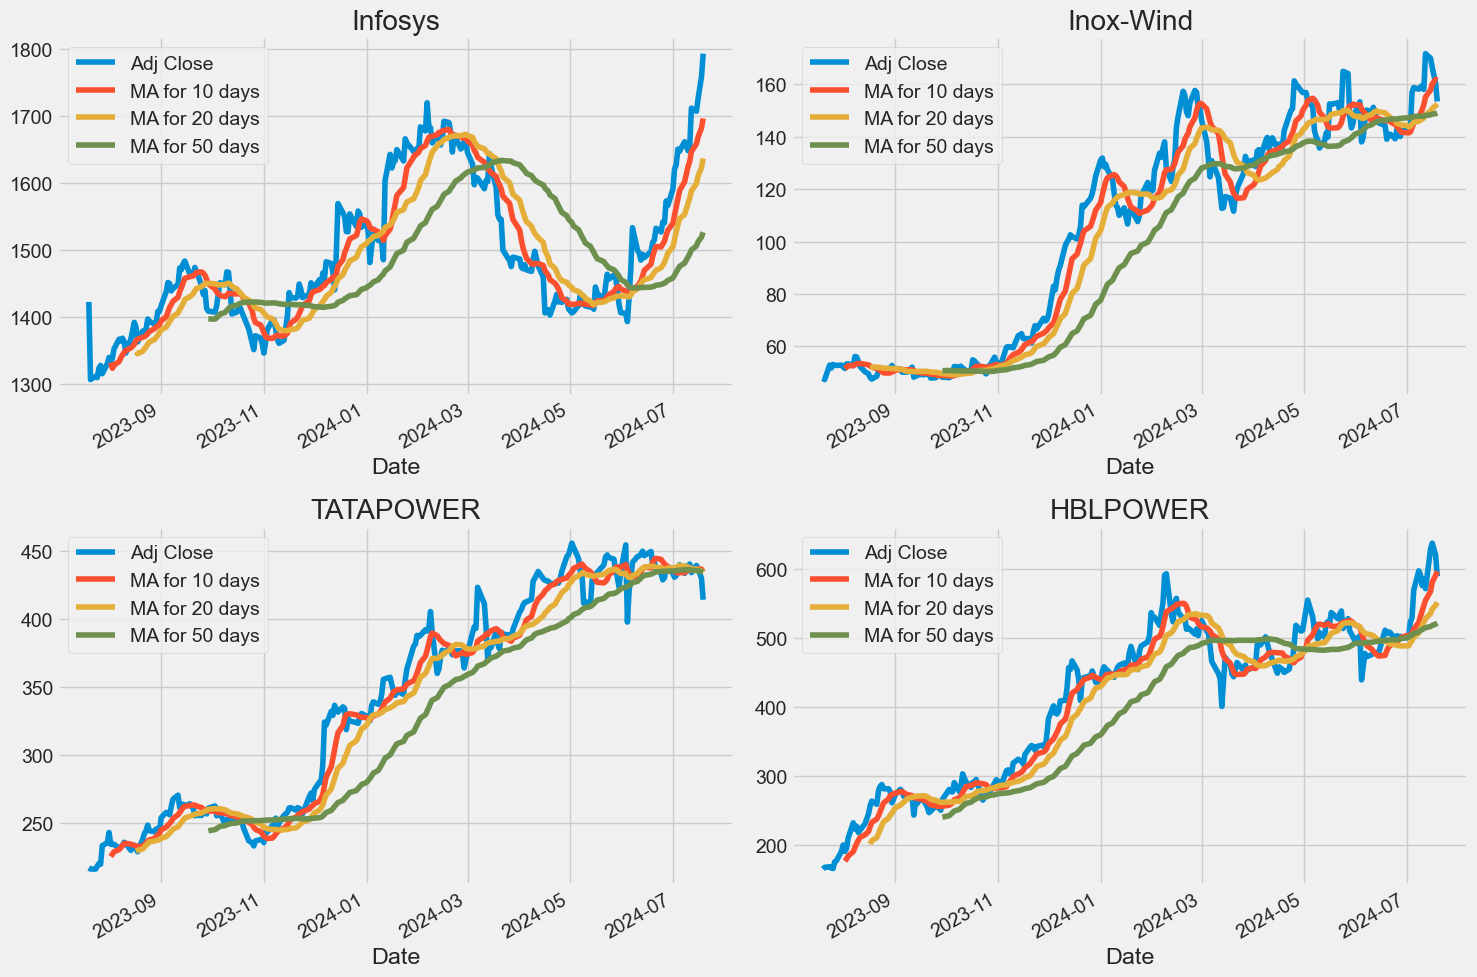

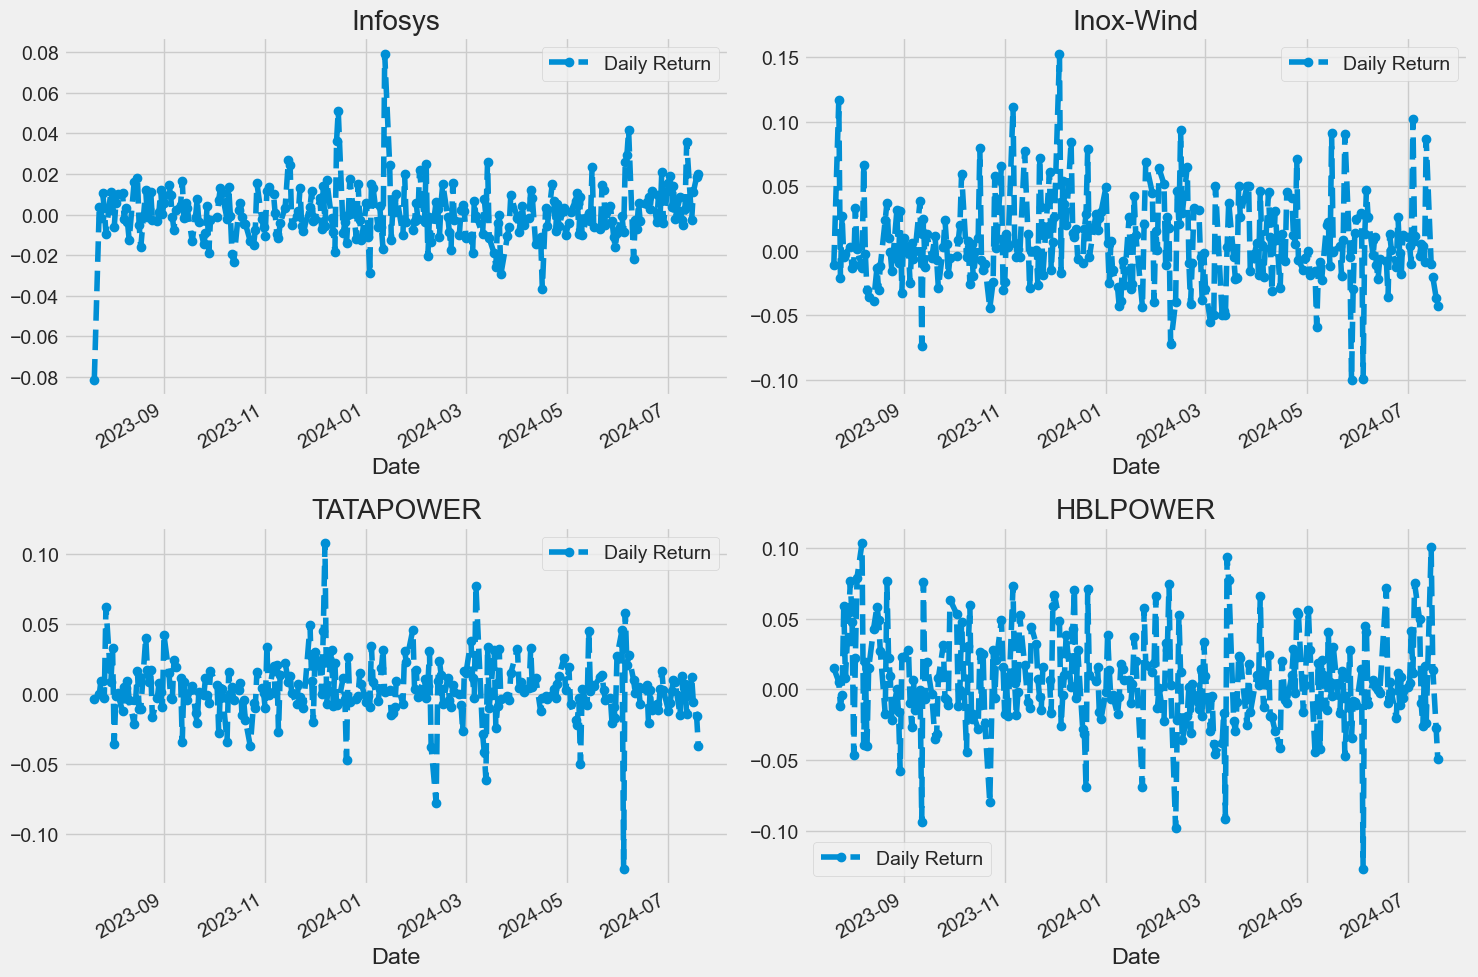

In [38]:
plot_stock_prices(company_list, company_name)
plot_stock_volumes(company_list, company_name)

add_moving_averages(company_list, [10, 20, 50])
plot_moving_averages(company_list, company_name)
plot_daily_returns(company_list, company_name)

[*********************100%%**********************]  4 of 4 completed


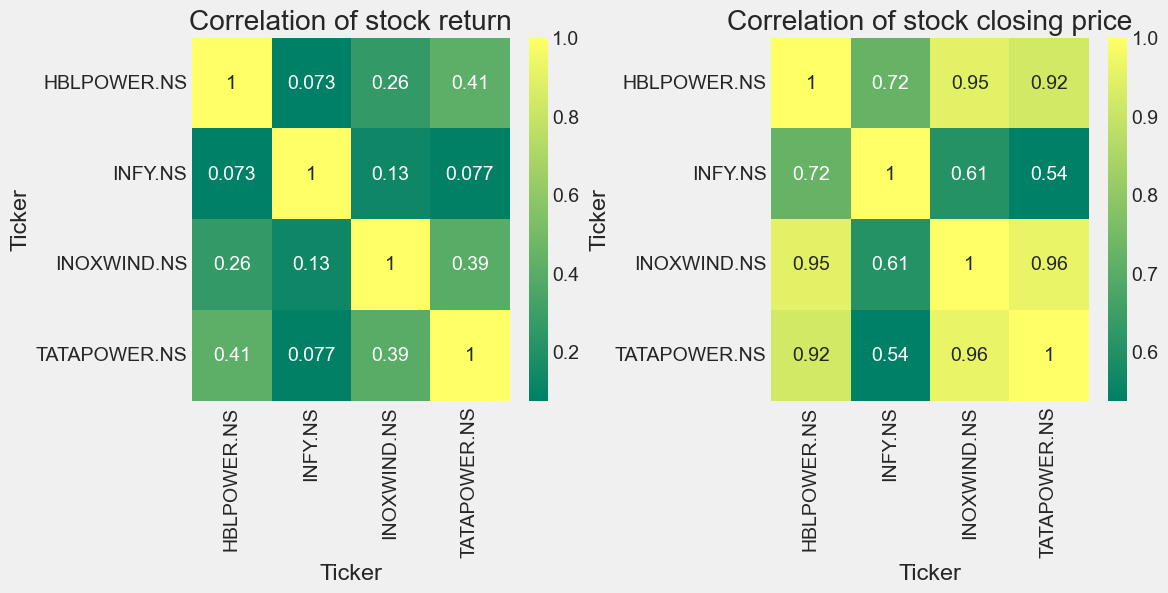

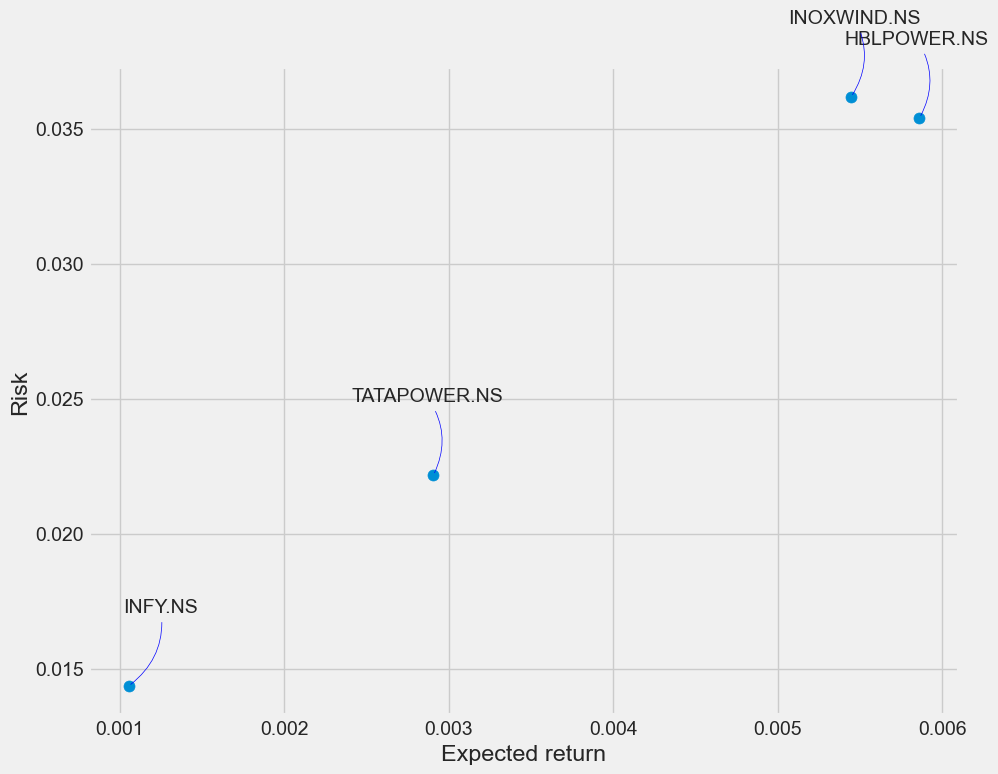

In [39]:
closing_df = yf.download(tech_list, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change().dropna()

plot_stock_correlations(tech_rets, closing_df)
plot_risk_return(tech_rets)

In [40]:
df = yf.download('INFY.NS', start=start, end=end)
x_train, y_train, scaler, training_data_len, data, dataset = prepare_data_for_lstm(df)

[*********************100%%**********************]  1 of 1 completed


In [41]:
model, history = build_and_train_lstm(x_train, y_train, epochs=20, batch_size=32)
predictions, rmse = evaluate_lstm(model, scaler, training_data_len, dataset)

Epoch 1/20
5/5 [==============================] - 8s 406ms/step - loss: 0.0979 - mse: 0.0979 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 2/20
5/5 [==============================] - 0s 97ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 3/20
5/5 [==============================] - 1s 121ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 4/20
5/5 [==============================] - 1s 124ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 5/20
5/5 [==============================] - 1s 117ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 6/20
5/5 [==============================] - 1s 121ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/20
5/5 [==============================] - 1s 169ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 8/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0099 - mse: 0.0099

RMSE: 62.47511037811755


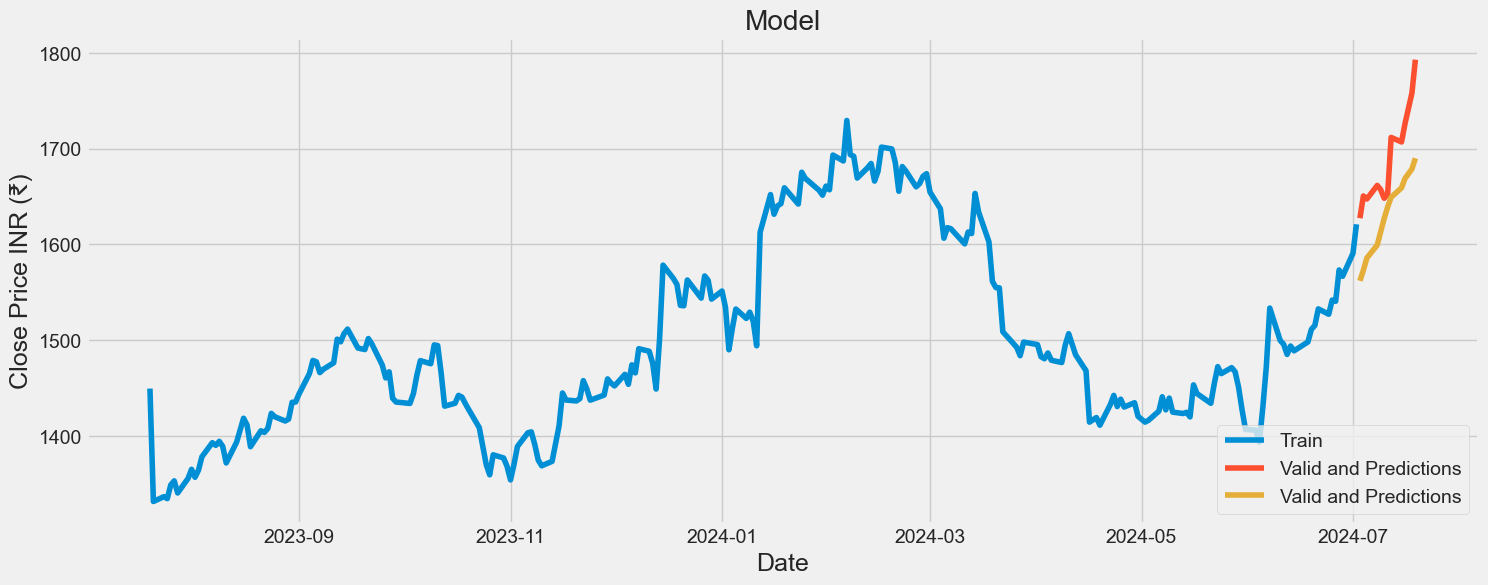

                  Close  Predictions
Date                                
2024-07-03  1627.400024  1561.996460
2024-07-04  1650.650024  1573.130981
2024-07-05  1647.449951  1585.850464
2024-07-08  1661.650024  1599.447876
2024-07-09  1657.150024  1613.485718


,Close,Predictions
Date,,
2024-07-03,1627.400024,1561.996460
2024-07-04,1650.650024,1573.130981
2024-07-05,1647.449951,1585.850464
2024-07-08,1661.650024,1599.447876
2024-07-09,1657.150024,1613.485718
2024-07-10,1648.250000,1627.080444
2024-07-11,1652.699951,1639.178711
2024-07-12,1711.750000,1649.295654
2024-07-15,1707.050049,1659.094116


In [42]:
print(f'RMSE: {rmse}')
plot_predictions(data, training_data_len, predictions)
# print(results_df.tail(10))

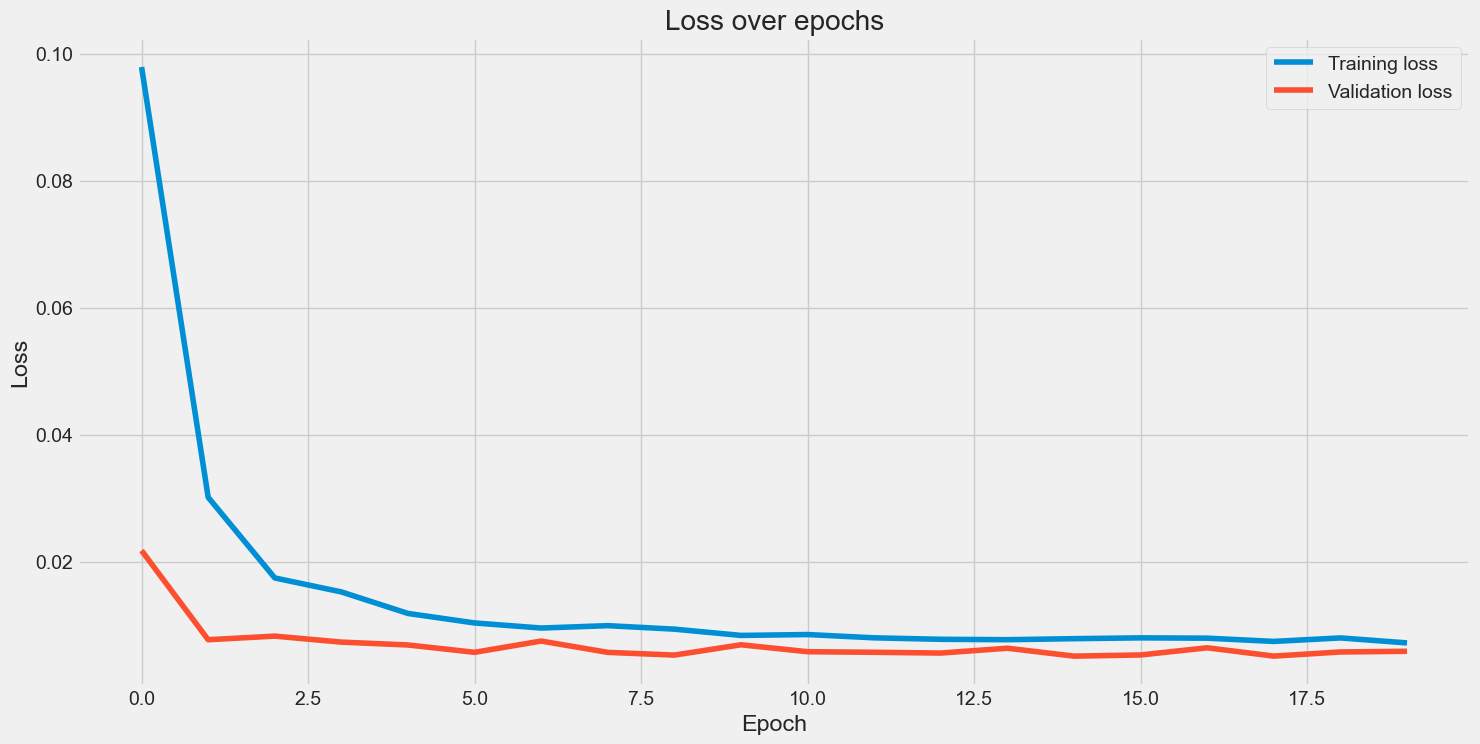

In [43]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
#for HBL power 
df = yf.download('HBLPOWER.NS', start=start, end=end)
x_train, y_train, scaler, training_data_len, data, dataset = prepare_data_for_lstm(df)

[*********************100%%**********************]  1 of 1 completed


In [45]:
model, history = build_and_train_lstm(x_train, y_train, epochs=20, batch_size=32)
predictions, rmse = evaluate_lstm(model, scaler, training_data_len, dataset)

Epoch 1/20
5/5 [==============================] - 7s 422ms/step - loss: 0.1156 - mse: 0.1156 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 2/20
5/5 [==============================] - 0s 96ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 3/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/20
5/5 [==============================] - 0s 92ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/20
5/5 [==============================] - 0s 91ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 6/20
5/5 [==============================] - 0s 100ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/20
5/5 [==============================] - 0s 96ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 8/20
5/5 [==============================] - 1s 104ms/step - loss: 0.0056 - mse: 0.0056 - 

RMSE: 64.86472376694691


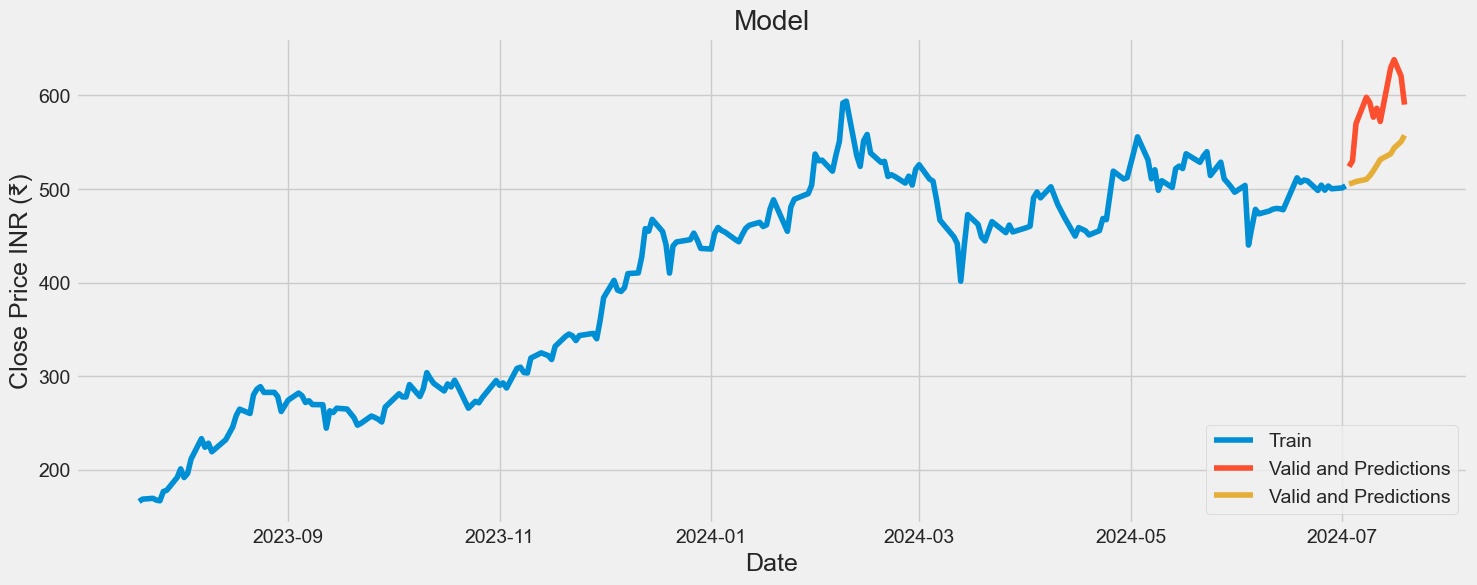

                 Close  Predictions
Date                               
2024-07-03  523.799988   505.253143
2024-07-04  530.000000   506.361786
2024-07-05  569.650024   507.806824
2024-07-08  597.849976   510.206818
2024-07-09  591.950012   514.073853


,Close,Predictions
Date,,
2024-07-03,523.799988,505.253143
2024-07-04,530.000000,506.361786
2024-07-05,569.650024,507.806824
2024-07-08,597.849976,510.206818
2024-07-09,591.950012,514.073853
2024-07-10,576.599976,519.255859
2024-07-11,586.099976,525.151611
2024-07-12,572.049988,531.393982
2024-07-15,629.349976,537.413513


In [46]:
print(f'RMSE: {rmse}')
plot_predictions(data, training_data_len, predictions)

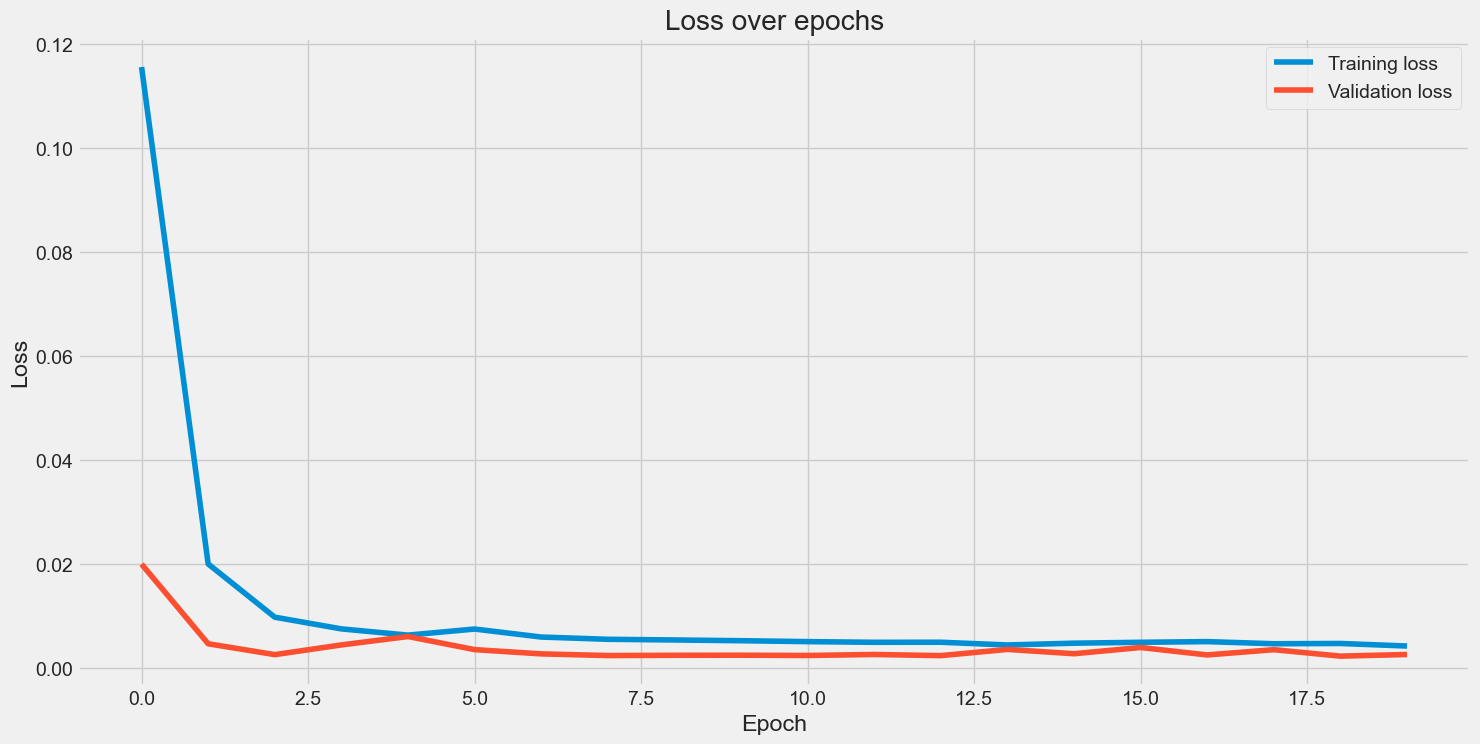

In [47]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()